# Image Classification

## Table of Contents
* [1. Setup and Load Data](#setup)
    - [1.1 Install Depedencies and Setup](#install)
    - [1.2 Remove Nonimages](#remove)
    - [1.3 Load Data](#load)
* [2. Preprocess Data](#preprocess)
    - [2.1 Scale Data](#scale)
    - [2.2 Split Data](#split)
* [3. Deep Model](#deep_model)
    - [3.1 Build Deep Learning Model](#build_model)
    - [3.2 Train Model](#train)
    - [3.3 Plot Performance](#performance)
* [4. Evaluate Performance](#evaluation)
    - [4.1 Evaluate](#evaluate)
    - [4.2 Testing Multiple Images](#test_multi)
    - [4.3 Testing Single Images](#test_single)
* [5. Save Model](#saving_model)

# 1. Setup and Load Data <a id="setup"></a>

### 1.1 Install Dependencies and Setup <a id="install"></a>

In [ ]:
!pip install tensorflow==2.10 tensorflow-gpu==2.10 opencv-python matplotlib

In [1]:
import tensorflow as tf
import os

In [2]:
## Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Remove Nonimages <a id="remove"></a>

In [3]:
import cv2
import imghdr

In [4]:
data_dir = 'data'
image_extensions = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
def remove_nonimage(image):
    try:
        img = cv2.imread(image)
        extension = imghdr.what(image)

        if extension not in image_extensions:
            print('Image not in extension list {}'.format(image))
            os.remove(image)
    except Exception as e:
        print('Issue with image {}'.format(image))
        os.remove(image)

for image_class in os.listdir(os.path.join(data_dir, 'training')):
    for image in os.listdir(os.path.join(data_dir, 'training', image_class)):
        image_path = os.path.join(data_dir, 'training', image_class, image)
        remove_nonimage(image_path)

### 1.3 Load Data <a id="load"></a>

Loads images into a data image pipeline. The <span style="color:#5886e8">image_dataset_from_directory</span> transforms data into a consistent shape and batch.  
All images transform to size (256, 256).

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

In [7]:
data = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'training'), batch_size = 15)
data = data.shuffle(buffer_size=2000, reshuffle_each_iteration= True)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

Found 3334 files belonging to 3 classes.


(15, 256, 256, 3)

<span style="color:#5886e8">batch</span> has 2 indexes the image and the class of the image (int)

In [8]:
class_names = np.array(os.listdir(os.path.join(data_dir, 'training')))
print(class_names)

['basketball' 'soccerball' 'volleyball']


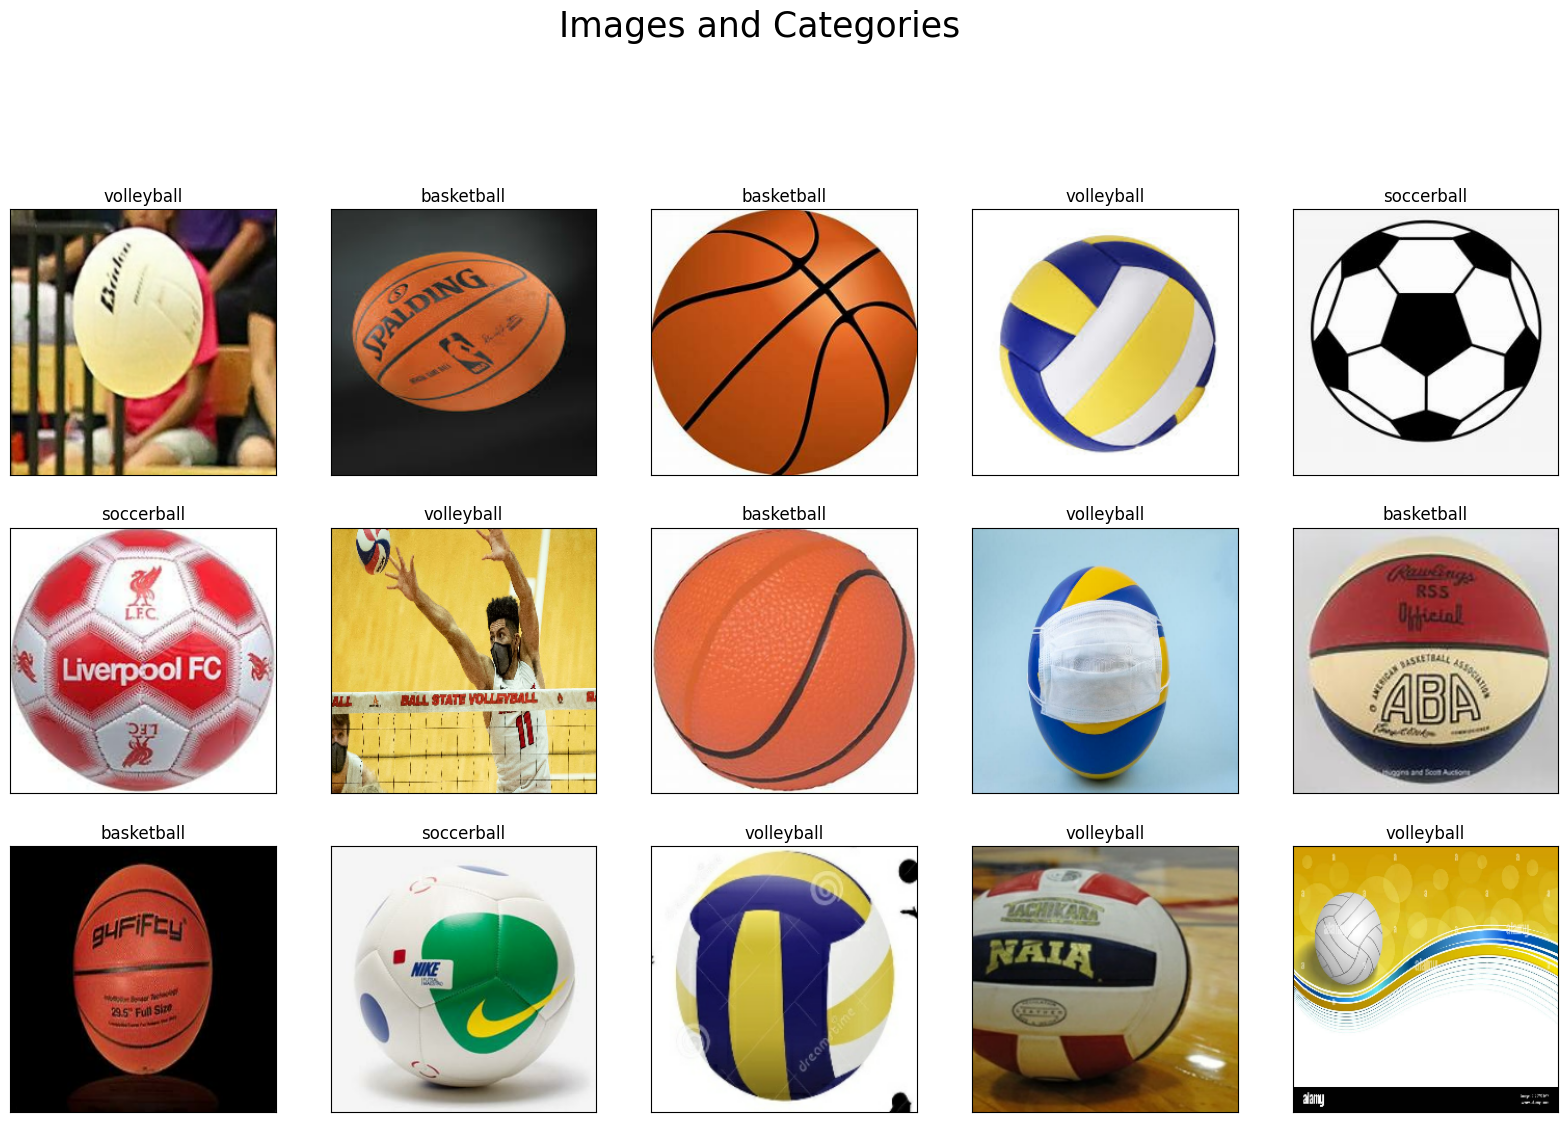

In [9]:
figsize = (20,20)
figure = plt.figure(figsize=figsize)
figure.suptitle("Images and Categories", fontsize=25)

for i in range(15):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.title(class_names[batch[1][i]])
plt.show()    

# 2. Preprocessing Data <a id="preprocess"></a>

* Scale the images values to be between 0-1 by dividing by 255. This helps our deep learning model journalize faster.   
* Split data into 70% training, 20% validation and 10% testing 

### 2.1 Scale Data <a id="scale"></a>

In [10]:
scaled_data = data.map(lambda x, y: (x/255, y))

In [11]:
batch = scaled_data.as_numpy_iterator().next()

# Checking scaling
print(batch[0].min())
print(batch[0].max())

0.0
1.0


### 2.2 Split Data <a id="split"></a>

In [12]:
train_size = int(len(data)*0.7)
validation_size = int(len(data)*0.2) + 1
test_size = int(len(data)*0.1)

print(train_size, validation_size, test_size, len(data))
if(train_size + validation_size + test_size != len(data)):
    print("Data does not add up to", len(data))

156 45 22 223


In [13]:
train = scaled_data.take(train_size)
validation = scaled_data.skip(train_size).take(validation_size)
test = scaled_data.skip(train_size + validation_size).take(test_size)

# 3. Deep Model <a id="deep_model"></a>

### 3.1 Build Deep Learning Model <a id="build_model"></a>

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [40]:
model = Sequential()

In [41]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(class_names)))

In [42]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)      

### 3.2 Train Model <a id="train"></a>

In [44]:
history = model.fit(train, epochs=15, validation_data=validation)

Epoch 1/15
156/156 [==============================] - 7s 29ms/step - loss: 0.8553 - accuracy: 0.6346 - val_loss: 0.7095 - val_accuracy: 0.7199
Epoch 2/15
156/156 [==============================] - 6s 29ms/step - loss: 0.6130 - accuracy: 0.7500 - val_loss: 0.4853 - val_accuracy: 0.8222
Epoch 3/15
156/156 [==============================] - 6s 29ms/step - loss: 0.4650 - accuracy: 0.8188 - val_loss: 0.3138 - val_accuracy: 0.8889
Epoch 4/15
156/156 [==============================] - 6s 28ms/step - loss: 0.3376 - accuracy: 0.8755 - val_loss: 0.2111 - val_accuracy: 0.9437
Epoch 5/15
156/156 [==============================] - 6s 28ms/step - loss: 0.2404 - accuracy: 0.9163 - val_loss: 0.1797 - val_accuracy: 0.9319
Epoch 6/15
156/156 [==============================] - 6s 29ms/step - loss: 0.1651 - accuracy: 0.9399 - val_loss: 0.1407 - val_accuracy: 0.9496
Epoch 7/15
156/156 [==============================] - 6s 28ms/step - loss: 0.1366 - accuracy: 0.9594 - val_loss: 0.0570 - val_accuracy: 0.9910

### 3.3 Plot Performance <a id="performance"><a/>

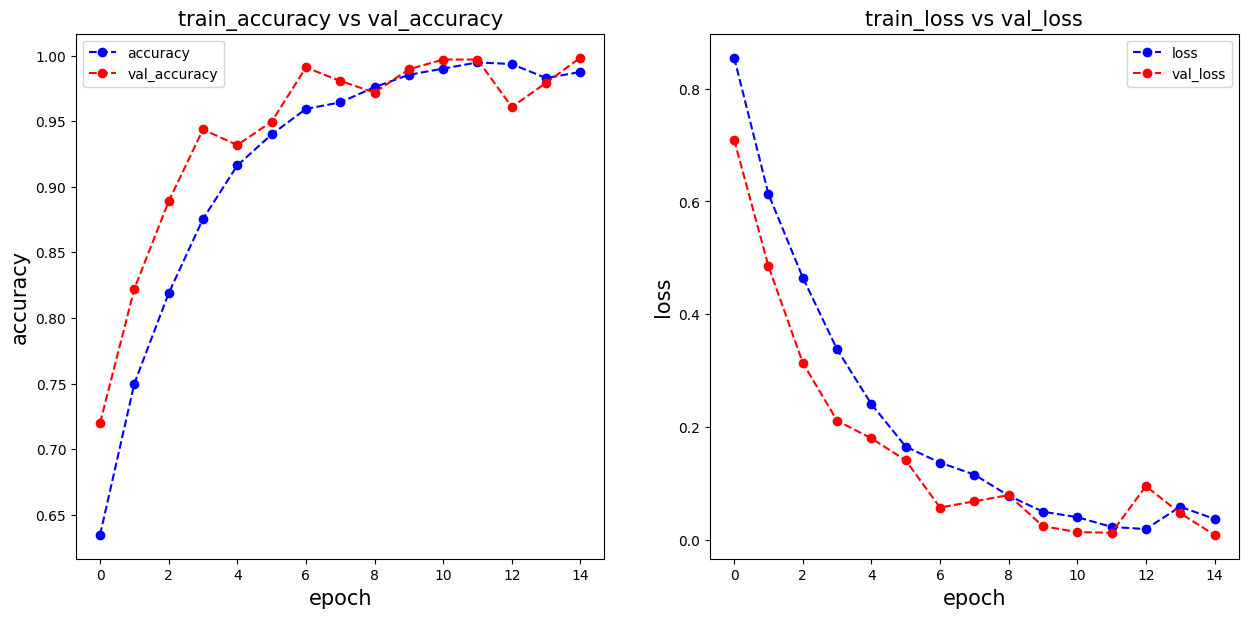

In [45]:
figure = plt.figure(figsize=(15,15))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'ro--', label = 'val_accuracy')
plt.title('train_accuracy vs val_accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label = 'loss')
plt.plot(history.history['val_loss'], 'ro--', label = 'val_loss')
plt.title('train_loss vs val_loss', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend()

plt.show()

# 4. Evaluate Performance <a id='evaluation'></a>

### 4.1 Evaluate <a id="evaluate"></a>

In [46]:
from sklearn.metrics import classification_report

In [47]:
test_list = []
predict_list = []

In [48]:
def predictList(batch):
    value_list = []
    
    for i in range(len(batch)):
        score = tf.nn.softmax(batch[i])
        value_list.append(np.argmax(score))
    return value_list

for batch in test.as_numpy_iterator():
    img, val = batch
    
    predict = model.predict(img)
    predict_list = np.append(predict_list, predictList(predict))
    test_list = np.append(test_list, val)

1/1 [==============================] - 0s 18ms/step


In [49]:
print(classification_report(test_list, predict_list))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       110
         1.0       1.00      1.00      1.00       111
         2.0       1.00      1.00      1.00       109

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330



### 4.2 Test Multiple Images <a id="test_multi"></a>

In [50]:
testing = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'))
scaled_test = testing.map(lambda x, y: (x/255, y))

testing_iterator = scaled_test.as_numpy_iterator()
batch = testing_iterator.next()

Found 20 files belonging to 3 classes.


In [51]:
test_category = np.array(os.listdir(os.path.join(data_dir, 'test')))
case_score = batch[1]

test_list = []
predict_list = []

1/1 [==============================] - 0s 14ms/step


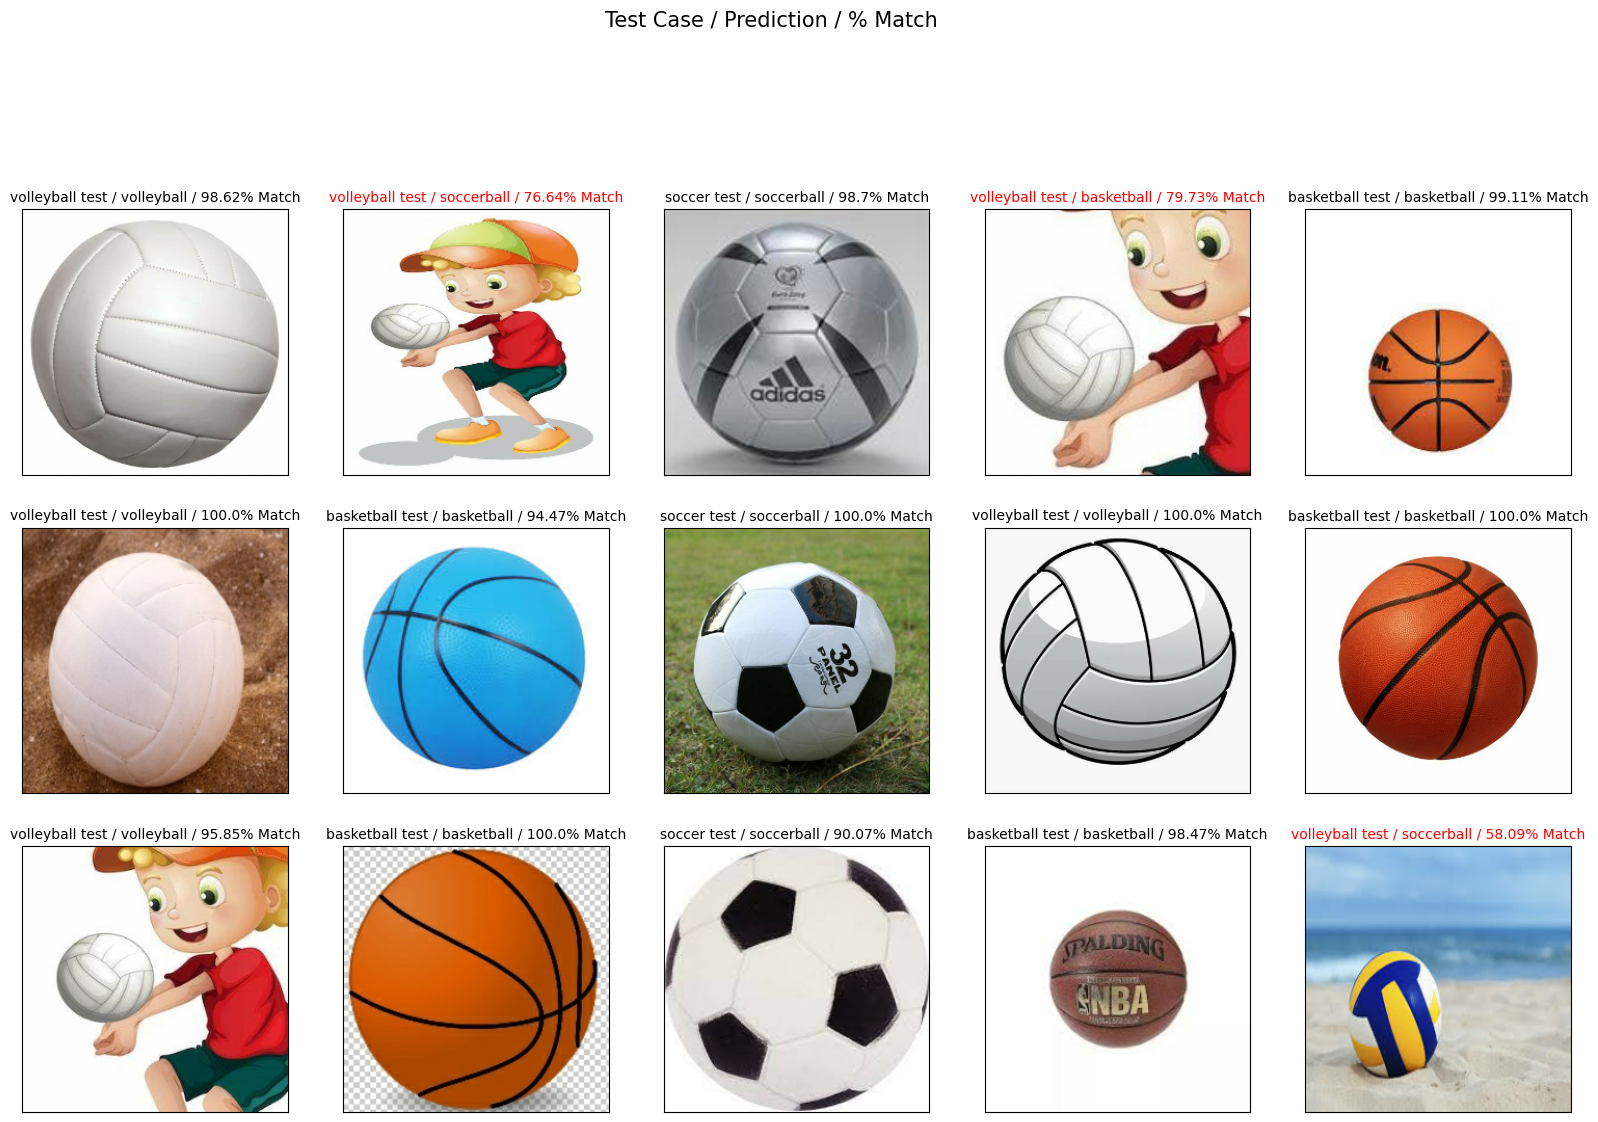

In [54]:
figsize = (20,20)
figure = plt.figure(figsize=figsize)
figure.suptitle("Test Case / Prediction / % Match", fontsize=15)

for i in range(15):
    predict = model.predict(np.expand_dims(batch[0][i], 0))
    score = tf.nn.softmax(predict[0])
    
    test_case = test_category[case_score[i]]
    predict_case = class_names[np.argmax(score)]
    percent_match = round(100*np.max(score), 2)
    font_color = 'black'
    
    if(case_score[i] != np.argmax(score)):
        font_color = 'red'
    
    plt.subplot(5,5, i+1)
    plt.title(f"{test_case} / {predict_case} / {percent_match}% Match", fontsize=10, color=font_color)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(batch[0][i])
    
    test_list = np.append(test_list, case_score[i])
    predict_list = np.append(predict_list, np.argmax(score))

In [55]:
print(classification_report(test_list, predict_list))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92        12
         1.0       0.69      1.00      0.82         9
         2.0       1.00      0.57      0.73        14

    accuracy                           0.83        35
   macro avg       0.85      0.86      0.82        35
weighted avg       0.87      0.83      0.82        35



### 4.3 Test Single Images <a id="test_single"></a>

In [56]:
test_path = 'soccer test\\soccerball.jpg'
img = cv2.imread(os.path.join('data\\test', test_path))

resize images and setting color to RGB to match the format of our training dataset

In [57]:
resize = tf.image.resize(img, (256, 256))
resize = cv2.cvtColor(resize.numpy(), cv2.COLOR_BGR2RGB)

In [58]:
predict = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 15ms/step


In [59]:
score = tf.nn.softmax(predict[0])
test_case = os.path.dirname(test_path)
predict_case = class_names[np.argmax(score)]
percent_match = round(100 * np.max(score), 2)

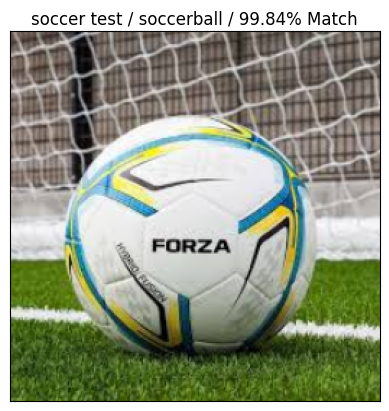

In [60]:
plt.imshow(resize.astype(int))
plt.xticks([])
plt.yticks([])
plt.title(f"{test_case} / {predict_case} / {percent_match}% Match")
plt.show()

# 5. Save Model <a id="saving_model"></a>

In [61]:
from tensorflow.keras.models import load_model

In [62]:
model.save(os.path.join('models', 'imageclassification.h5'))

In [63]:
new_model = load_model('models\\imageclassification.h5')

In [64]:
predict = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 50ms/step


In [65]:
score = tf.nn.softmax(predict[0])
test_case = os.path.dirname(test_path)
predict_case = class_names[np.argmax(score)]
percent_match = round(100 * np.max(score), 2)

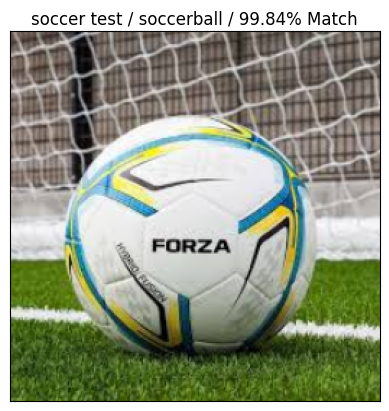

In [66]:
plt.imshow(resize.astype(int))
plt.xticks([])
plt.yticks([])
plt.title(f"{test_case} / {predict_case} / {percent_match}% Match")
plt.show()